In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader
from torchvision import transforms


In [2]:
if __name__ == "__main__":

    # =========================================================================
    #       DIRECTORIES
    # =========================================================================
    modelDir = os.path.join(os.path.dirname(os.getcwd()), 'saved_models')
    dataDir  = os.path.join(os.getcwd(), 'dataset')
    trainDir = os.path.join(dataDir, 'train')
    testDir  = os.path.join(dataDir, 'test')

    # =========================================================================
    #       LOADING DATASET
    # =========================================================================
    train = pd.read_csv(os.path.join(dataDir, 'train.csv'))
    test  = pd.read_csv(os.path.join(dataDir, 'test.csv'))

    # =========================================================================
    #       PREPARING IMAGES TRANSFORMATIONS
    # =========================================================================
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    trainTransform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(mean, std)])
    validTransform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(mean, std)])
    testTransform  = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(mean, std)])
                                   

In [11]:
train.head()

,id,label
2452,2237b56e9f8a45a5934ad8b056d09e2a.jpg,0
1993,1bd940aff7ceaa26c3ad1d2f71065f79.jpg,0
15259,dedf3c8be3a104d92b5fdaafbddbb925.jpg,1
13357,c1e4711af0810d53804a30940f7ce79f.jpg,1
2157,1e31d7adbe6ec077dd1e5694c7f7ba98.jpg,1


In [ ]:
train['label'].value_counts()

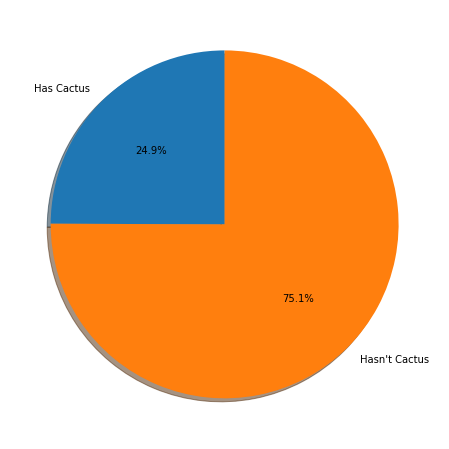

In [10]:
label = 'Has Cactus', 'Hasn\'t Cactus'
plt.figure(figsize = (8,8))
plt.pie(train.groupby('label').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

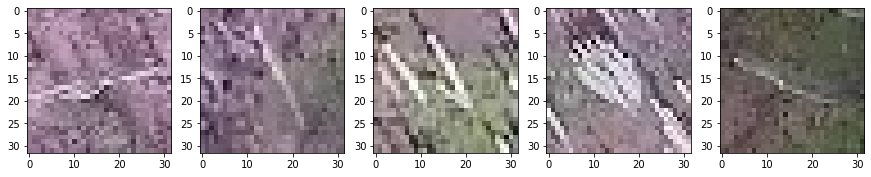

In [14]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(train[train['label'] == 1]['id'][-5:]):
    path = os.path.join(trainDir, idx)
    ax[i].imshow(img.imread(path))

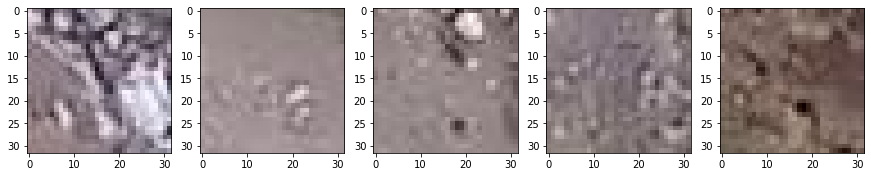

In [15]:
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(train[train['label'] == 0]['id'][:5]):
    path = os.path.join(trainDir, idx)
    ax[i].imshow(img.imread(path))

In [3]:
    # =========================================================================
    #       SPLITING DATASET : training and validation
    # =========================================================================
    train, validation = train_test_split(train, stratify=train.label, test_size=0.1)  # 10% for validation

    from CactusDataset import CactusDataset
    trainData = CactusDataset(train, trainDir, trainTransform)
    validData = CactusDataset(validation, trainDir, validTransform)
    testData  = CactusDataset(test, testDir, testTransform)


In [4]:
    # =========================================================================
    #       HYPER PARAMETERS / CUDA / DATALOADER
    # =========================================================================
    from config import config

    # hyper parameters
    epochs  = config['epochs']
    classes = config['classes']
    batchSize = config['batchSize']
    workers = config['workers']

    # load each dataset
    trainLoader = DataLoader(dataset=trainData, batch_size=batchSize, shuffle=True, num_workers=workers)
    validLoader = DataLoader(dataset=validData, batch_size=batchSize, shuffle=False, num_workers=workers)
    testLoader  = DataLoader(dataset=testData, batch_size=batchSize, shuffle=False, num_workers=workers)

In [5]:
    # =========================================================================
    #       INIT TRAINING
    # =========================================================================
    from CNN_v2 import model, optimizer, criterion
    from utils import training
    
    train_losses, val_losses = [], []

    for epoch in tqdm(range(epochs)):
        training(epoch, model, optimizer, criterion, 
                 trainLoader, validLoader, train_losses, val_losses)


100%|██████████| 35/35 [19:11<00:00, 32.89s/it]Epoch: 34 Training Loss: 0.046574 Validation Loss: 0.026574



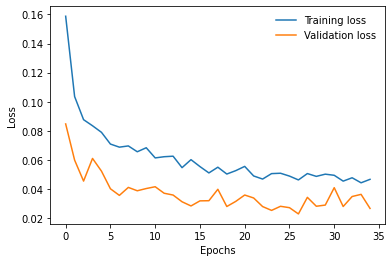

In [7]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [8]:
    # =========================================================================
    #       EVALUATING AND SAVING THE MODEL
    # =========================================================================
    from utils import evaluate
    SAVE_MODE = False

    accuracy = evaluate(model, validLoader)
    print('ACCURACY : {}'.format(accuracy))

    if SAVE_MODE:
        torch.save(model.state_dict(), os.path.join(modelDir, 'cactusModel.ckpt'))


ACCURACY : 99.2
